# fig — mnist to imgnet (final)

**Motivation**: host = ```mach```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def _process_cifar(dl):
    x_down = []
    for x, *_ in iter(dl):
        x_down.append(F.interpolate(
            input=x,
            size=(28, 28),
            mode='bilinear',
            antialias=True,
        ))
    x_down = torch.cat(x_down)
    x_down = (1 + x_down) / 2
    x_down *= mask_mnist

    kws_dataloader = dict(
        batch_size=2000,
        drop_last=False,
        shuffle=False,
    )
    ds_down = torch.utils.data.TensorDataset(
        x_down, dl.dataset.tensors[1])
    dl_down = torch.utils.data.DataLoader(
        ds_down, **kws_dataloader)
    return dl_down


def rgb_to_grayscale(image):
    # Coefficients for converting RGB to grayscale
    r, g, b = image[:, 0, :, :], image[:, 1, :, :], image[:, 2, :, :]
    gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray_image.unsqueeze(1)  # Add back the channel dimension


def _process_imgnet(dl):
    x, g = dl.dataset.tensors
    
    x = rgb_to_grayscale(x)
    x_down = F.interpolate(
        input=x,
        size=(28, 28),
        mode='bilinear',
        antialias=True,
    )
    x_down = (1 + x_down) / 2
    x_down *= mask_mnist.to(x_down.device)

    kws_dataloader = dict(
        batch_size=1500,
        drop_last=False,
        shuffle=False,
    )
    ds_down = torch.utils.data.TensorDataset(x_down, g)
    dl_down = torch.utils.data.DataLoader(ds_down, **kws_dataloader)
    return dl_down

In [3]:
from analysis.chosen import *
from figures.analysis import *
from analysis.final import save_both_row_col

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: mach

In [4]:
fig_dir = pjoin(fig_base_dir, 'iclr_oct02', 'mnist_to_imgnet')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'recons-across-time_ia-VAE (s).png',
    'recons-across-time_iP-VAE.png',
    'cropped-recons-across-time_ia-VAE (s).png',
    'convergence_mnist2imgnet.pdf',
    'cropped-recons-across-time_ia-VAE (h).png',
    'recons-across-time_ia-VAE (h).png',
    'cropped-recons-across-time_sa-VAE.png',
    'cropped-recons-across-time_iP-VAE.png',
    'recons-across-time_sa-VAE.png'
]

## iP-VAE

In [5]:
models_to_load = selected_models_28x28(device, full=True)

_PVAE_MODELS = [
    'MNIST_<jacob|mlp>_(64,24.0)',
    # 'MNIST_<jacob|conv>_(16,8.0)',
    # 'Omniglot_<jacob|mlp>_(64,24.0)',
    # 'Omniglot_<jacob|conv>_(16,8.0)',
]
models_to_load = {
    m: d for m, d in
    models_to_load.items()
    if m in _PVAE_MODELS
}
models_to_load = dict(sorted(
    models_to_load.items(),
    key=lambda t: alphanum_sort_key(t[0]),
))
print(list(models_to_load))

['MNIST_<jacob|mlp>_(64,24.0)']

In [6]:
trainers = {}
for name, kwargs in tqdm(models_to_load.items()):
    tr = load_model(**kwargs)[0]
    tr.cfg.batch_size = 2000
    trainers[name] = tr

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


In [7]:
tr = trainers['MNIST_<jacob|mlp>_(64,24.0)']
var_mnist = torch.var(tr.dl_trn.dataset.tensors[0], dim=0, keepdim=True)
mask_mnist = var_mnist / torch.max(var_mnist)

var_mnist.shape

torch.Size([1, 1, 28, 28])

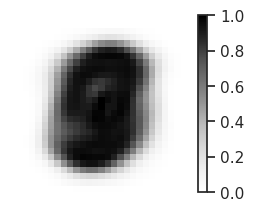

In [8]:
fig, ax = create_figure()
im = ax.imshow(tonp(mask_mnist.squeeze()), cmap='Greys')
plt.colorbar(im, ax=ax)
remove_ticks(ax)
plt.show()

## ImgNet32 downsample

In [9]:
%%time

from base.dataset import make_dataloader

vld = make_dataloader('ImageNet32', 'cpu', grey=True, skip_trn=True)[1]
vld = _process_imgnet(vld)

CPU times: user 14.3 s, sys: 5.67 s, total: 20 s
Wall time: 666 ms


In [10]:
vld.dataset.tensors[0].min(), vld.dataset.tensors[0].max()

(tensor(0.), tensor(1.0000))

In [ ]:
tr = trainers['MNIST_<jacob|mlp>_(64,24.0)']

results = tr.analysis(
    dl=vld,
    seq_total=1_000,
    n_data_batches=None,
)

100%|█████████████████████████████████| 25/25 [01:48<00:00,  4.34s/it]


In [ ]:
_ = plot_convergence(results)

## Make MSE plot

### Load Dekel Data

In [ ]:
dekel_dir = '/home/hadi/Dropbox/git/jb-vae/tmp/dekel_data/rot_full'

imgnet_dekel = {
    'sa-VAE': 'SAVAE_from-mnist-to-imagenet-val-_iter1000_full_save-all-recons_for_hadi.npz',
    'ia-VAE (h)': 'MARINO_hierarchical_from-mnist-to-imagenet-val_MNIST_H_iters1000_full_save-all-recons_for_hadi.npz',
    'ia-VAE (s)': 'MARINO_single_level_from-mnist-to-imagenet-val_MNIST_SL_iters1000_full_save-all-recons_mse.npz.npy',
}

In [ ]:
mse_data = {}

for name, f in imgnet_dekel.items():
    try:
        load = dict(np.load(pjoin(dekel_dir, f)))
        mse_data[name] = load['mse'][1:]
    except TypeError:
        load = np.load(pjoin(dekel_dir, f))
        mse_data[name] = load[1:]

mse_data['iP-VAE'] = results['mse']

In [ ]:
rename_marino_models = {
    'ia-VAE (single-level)': 'ia-VAE (s)',
    'ia-VAE (hierarchical)': 'ia-VAE (h)',
}

pal_models = get_palette_models()

for name, new_name in rename_marino_models.items():
    pal_models[new_name] = pal_models.pop(name)

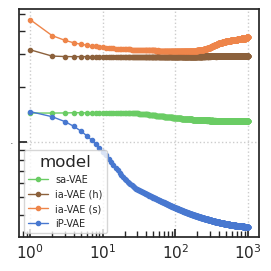

In [44]:
fig, ax = create_figure(1, 1, (2.6, 2.6))

for name, mse in mse_data.items():
    ax = convergence_subplot(ax, mse, name, color=pal_models[name], legend_title='model', legend=True)
ax.tick_params(direction='in', which='both')
sns.move_legend(ax, 'best', fontsize=7)
ax.tick_params(axis='y', labelsize=0)
# move_legend(ax, (1, 1.035))
ax.grid()

In [45]:
fig.savefig(pjoin(fig_dir, 'convergence_mnist2imgnet.pdf'), **kws_fig)

## Plot recons across time

In [18]:
selected_inds = [
    7916, 2146, 5931, 7463, 5540, 2937, 6983,
    5313, 1375, 1712, 3320, 3633, 5818, 6268,
    6489, 5598, 5779, 4809, 2561, 3886, 7511,
]
selected_inds_final = [
    2146, 5931, 7463, 6268, 3633,
    5779, 4809, 2561, 7511,
]
dekel_reindexing = [
    selected_inds.index(i)
    for i in selected_inds_final
]
len(selected_inds), len(selected_inds_final)

(21, 9)

In [24]:
dekel_dir = '/home/hadi/Dropbox/git/jb-vae/tmp/dekel_data/rot_full'

imgnet_dekel = {
    'sa-VAE': 'SAVAE_from-mnist-to-imagenet-val-_iter1000_full_save-all-recons_for_hadi.npz',
    'ia-VAE (h)': 'MARINO_hierarchical_from-mnist-to-imagenet-val_MNIST_H_iters1000_full_save-all-recons_for_hadi.npz',
    'ia-VAE (s)': 'MARINO_single_level_from-mnist-to-imagenet-val_MNIST_SL_iters1000_full_save-all-recons_for_hadi.npz',
}

In [26]:
src = tonp(vld.dataset.tensors[0][selected_inds_final].squeeze())

recon_data = np.load(pjoin(tmp_dir, 'mnist-to-imgnet_recon-full.npy'))
recon_data = {'iP-VAE': recon_data[selected_inds_final].reshape(-1, 1000, 28, 28)}

for name, f in imgnet_dekel.items():
    load = dict(np.load(pjoin(dekel_dir, f)))
    recon = load['recons'][dekel_reindexing]
    if np.nanmax(recon) > 1:
        recon /= 255
    recon_data[name] = recon[:, 1:]

In [27]:
print({k: v.shape for k, v in recon_data.items()})

{
    'iP-VAE': (9, 1000, 28, 28),
    'sa-VAE': (9, 1000, 28, 28),
    'ia-VAE (h)': (9, 1000, 28, 28),
    'ia-VAE (s)': (9, 1000, 28, 28)
}

iP-VAE

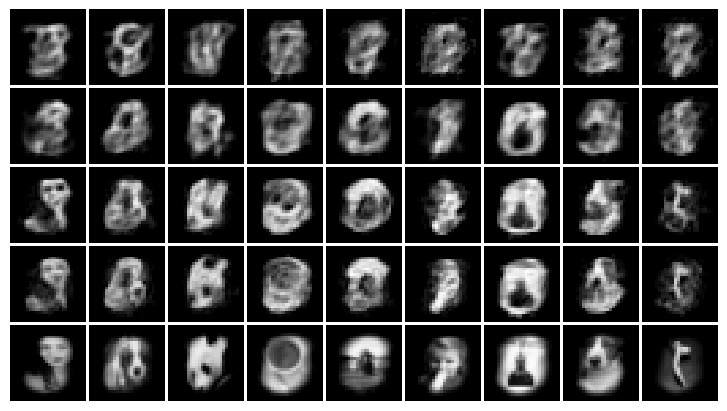

sa-VAE

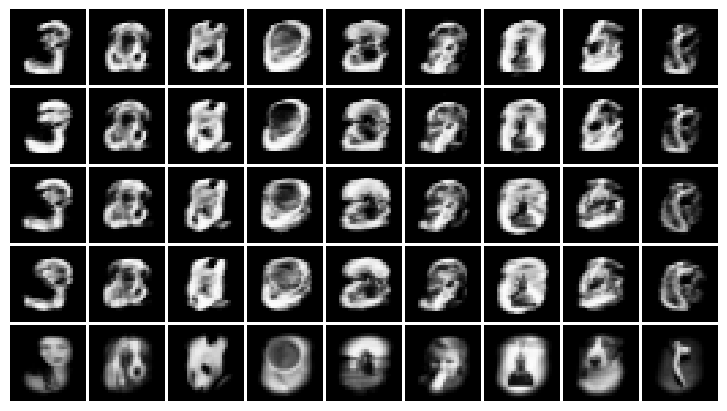

ia-VAE (h)

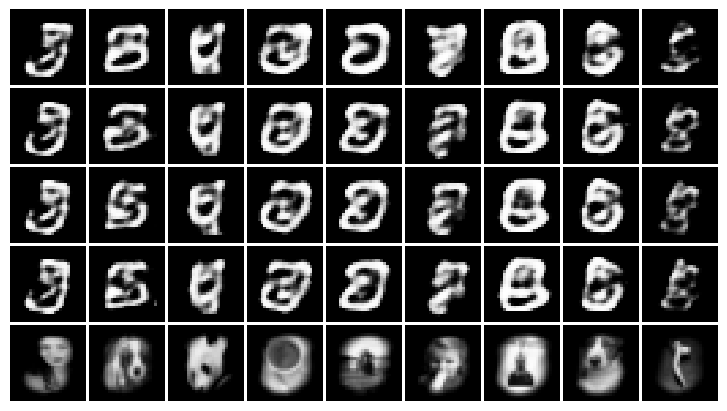

ia-VAE (s)

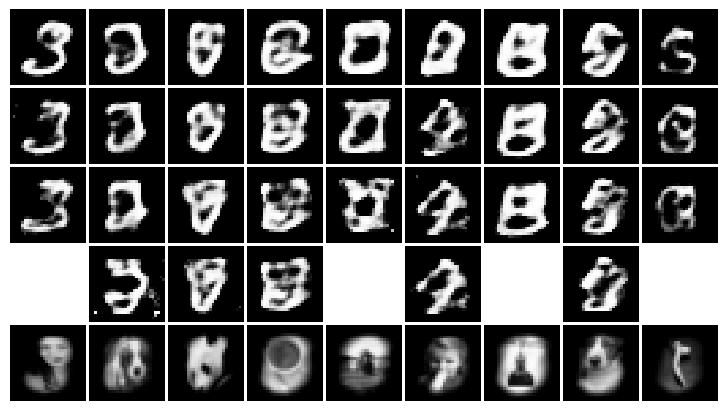

In [28]:
for model, x in recon_data.items():
    print(model)
    
    x2p = []
    for t in [0, 9, 99, 999]:
        x2p.append(x[:, t])
    x2p.append(src)
    x2p = np.concatenate(x2p)

    fig, ax = plot_weights(x2p, nrows=5, method='none', dpi=100, cmap='Greys_r', vmin=0.05, vmax=1.0)
    fig.savefig(pjoin(fig_dir, f'recons-across-time_{model}.png'), **kws_fig)

## Cropped boundaries

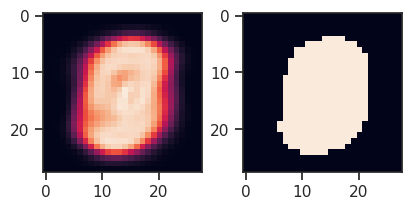

In [76]:
mask_mnist_bool = mask_mnist > 0.5
mask_mnist_bool = mask_mnist_bool.squeeze()

fig, axes = create_figure(1, 2, (4, 2))
axes[0].imshow(tonp(mask_mnist.squeeze()))
axes[1].imshow(tonp(mask_mnist_bool))
plt.show()

In [77]:
src_cropped = np.stack(filter_boundaries(
    [a for a in src],
    tonp(mask_mnist_bool),
))
# nans_array = np.ones((9, 3, 18)) * np.nan
# src_cropped = np.concatenate([
#     nans_array,
#     src_cropped
# ], axis=1)
src_cropped.shape

(9, 21, 16)

iP-VAE

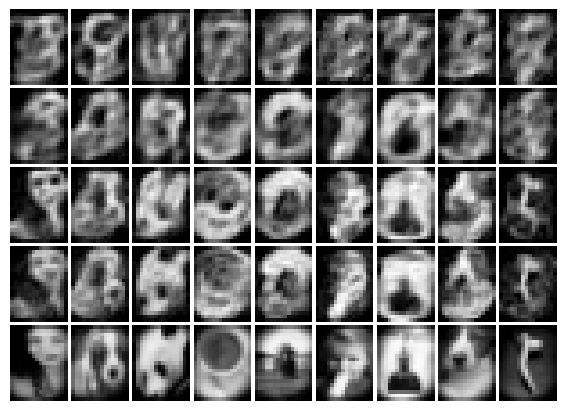

sa-VAE

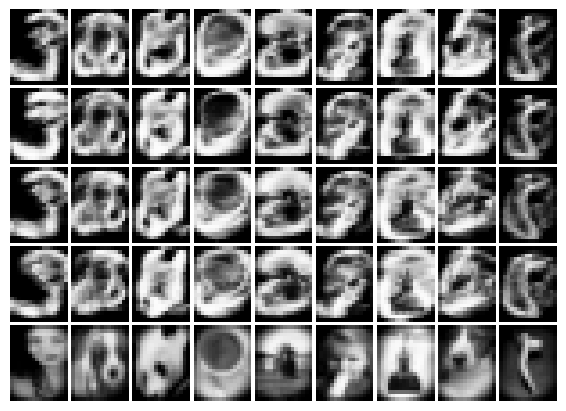

ia-VAE (h)

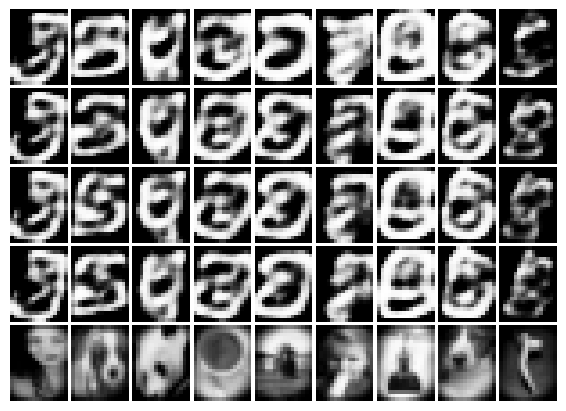

ia-VAE (s)

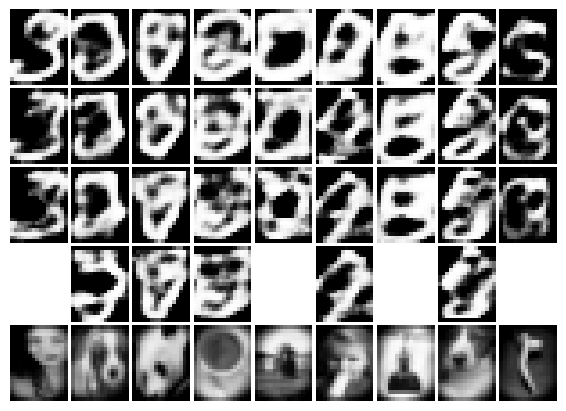

In [79]:
for model, x in recon_data.items():
    print(model)
    
    x2p = []
    for t in [0, 9, 99, 999]:
        cropped = np.stack(filter_boundaries(
            [a for a in x[:, t]],
            tonp(mask_mnist_bool),
        ))
        x2p.append(cropped)
    x2p.append(src_cropped)
    x2p = np.concatenate(x2p)

    fig, ax = plot_weights(x2p, nrows=5, method='none', dpi=100, cmap='Greys_r', vmin=0.05, vmax=1.0)
    fig.savefig(pjoin(fig_dir, f'cropped-recons-across-time_{model}.png'), **kws_fig)

In [53]:


def filter_boundaries(
		x_list: Union[np.ndarray, List[np.ndarray]],
		mask: np.ndarray = None, ):
	if not isinstance(x_list, list):
		x_list = [x_list]
	if mask is None:
		# noinspection PyTypeChecker
		mask = functools.reduce(
			np.logical_or,
			[x.astype(bool) for x in x_list]
		)
	dim = len(mask.shape)

	if dim == 2:
		bad_x_indices = np.where(mask.mean(1) == 0)[0]
		bad_y_indices = np.where(mask.mean(0) == 0)[0]
		bad_z_indices = []
	elif dim == 3:
		bad_x_indices = np.where(mask.mean(-1).mean(-1) == 0)[0]
		bad_y_indices = np.where(mask.mean(0).mean(-1) == 0)[0]
		bad_z_indices = np.where(mask.mean(0).mean(0) == 0)[0]
	else:
		raise ValueError("wrong dim: {}".format(dim))

	filtered = []
	for x in x_list:
		if dim == 2:
			x_filtered = np.delete(np.delete(
				x, bad_y_indices, axis=1), bad_x_indices, axis=0)
		elif dim == 3:
			x_filtered = np.delete(np.delete(np.delete(
				arr=x, obj=bad_z_indices, axis=2,
			), obj=bad_y_indices, axis=1,
			), obj=bad_x_indices, axis=0,
			)
		else:
			raise ValueError("wrong dim: {}".format(dim))
		filtered.append(x_filtered)
	return filtered if len(filtered) > 1 else filtered.pop()

## Radnom 64

In [20]:
recon_full = np.load(pjoin(tmp_dir, 'mnist-to-imgnet_recon-full.npy'))
recon_full.shape

(8000, 1000, 784)

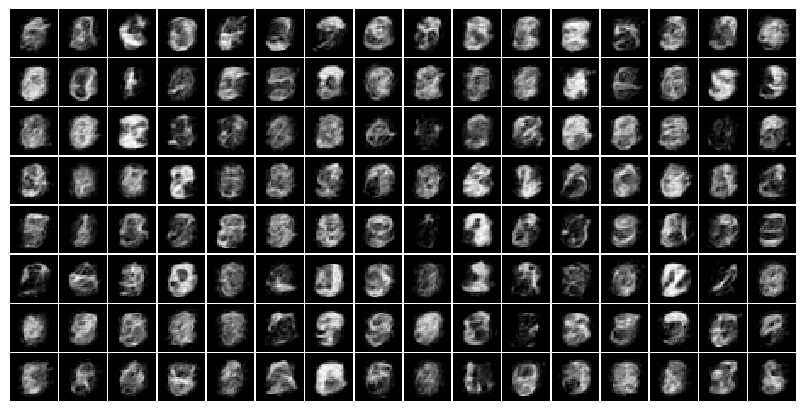

In [25]:
inds = np.random.choice(range(len(recon_full)), 128, replace=False)

fig, ax = plot_weights(
    recon_full[inds, -1].reshape(-1, 28, 28),
    nrows=8, method='none', dpi=100,
    cmap='Greys_r', vmin=0.05, vmax=1.,
)
# fig.savefig(pjoin(fig_dir, f'recons-across-time_{model}.png'), **kws_fig)

In [23]:
recon_full[inds, -1].shape

(64, 784)